https://www.kaggle.com/myonin/music-recommendation-random-forest-xgboost

In [35]:
# Load Python libraries
from sklearn import metrics, ensemble
from sklearn.model_selection import cross_validate,GridSearchCV,train_test_split
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [9]:
# Load data
df = pd.read_csv('input/train.csv')

# 1% sample of items
df = df.sample(frac=0.01)

In [11]:
# Load and join songs data
songs = pd.read_csv('input/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load and join songs data
members = pd.read_csv('input/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73774 entries, 0 to 73773
Data columns (total 18 columns):
msno                      73774 non-null object
song_id                   73774 non-null object
source_system_tab         73532 non-null object
source_screen_name        69643 non-null object
source_type               73571 non-null object
target                    73774 non-null int64
song_length               73774 non-null int64
genre_ids                 72585 non-null object
artist_name               73774 non-null object
composer                  56931 non-null object
lyricist                  41797 non-null object
language                  73774 non-null float64
city                      73774 non-null int64
bd                        73774 non-null int64
gender                    44208 non-null object
registered_via            73774 non-null int64
registration_init_time    73774 non-null int64
expiration_date           73774 non-null int64
dtypes: float64(1), int64(7), obj

In [13]:
# Count Na in %
df.isnull().sum()/df.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.328029
source_screen_name         5.599534
source_type                0.275165
target                     0.000000
song_length                0.000000
genre_ids                  1.611679
artist_name                0.000000
composer                  22.830537
lyricist                  43.344539
language                   0.000000
city                       0.000000
bd                         0.000000
gender                    40.076450
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [14]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [15]:
# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [16]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,8tSgHKzljg7TyPLYrU9L7CgHIdShVvyV/d6PccMRzhw=,XywYVZbNMapxoPCNykyH/VQ+RElMw2PrF/6tVhUbgS8=,my library,Album more,album,0,125945,2022,RADWIMPS,Akira Kuwahara,...,unknown,3,2014-07-18,2017-10-22,2014,7,18,2017,10,22
1,AvQSYlMMiYYNMDd+wAuwT0B2yiPuNxGDxai/B4rrWII=,43Qm2YzsP99P5wm37B1JIhezUcQ/1CDjYlQx6rBbz2U=,my library,unknown,top-hits-for-artist,0,346272,458,五月天 (Mayday),怪獸,...,female,9,2004-03-31,2017-10-27,2004,3,31,2017,10,27
2,UTAElx4+rSh2QViTKHQhC40cphX7ZIYafAOMJOJCshY=,bEJY4dTNVSWM9fPtWc5ZPKyEcxcM1n/DMstAcBlyV2I=,my library,Local playlist more,local-library,0,246595,465,A-Lin,劉勇志,...,female,3,2012-06-14,2018-01-15,2012,6,14,2018,1,15
3,PGLwS5B5V0FHwHUVdLTWiN0liEWZtXCF3YN1Lv+aH5M=,v/3onppBGoSpGsWb8iaCIO8eX5+iacbH5a4ZUhT7N54=,discover,Online playlist more,online-playlist,1,161175,1616|1609,Alan Walker,Alan Walker| Jesper Borgen| Anders Froen| Gunn...,...,female,9,2004-09-04,2018-05-26,2004,9,4,2018,5,26
4,8ehTcq2hI/iwZwJmRJqgPrLqmEPDGI4WaB/JiG2R/b0=,vkagi2Lrvjx/FxLWE6FHZFoDoOaSWI052fEQCwouDUs=,discover,Online playlist more,online-playlist,0,287869,465,李榮浩,Li Rong Hao,...,unknown,7,2015-08-15,2017-10-06,2015,8,15,2017,10,6


In [17]:
# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [18]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

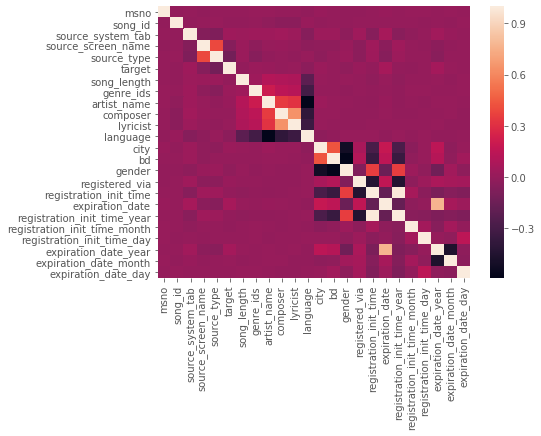

In [19]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
sns.heatmap(df.corr())
plt.show()

In [20]:
# Drop columns
df = df.drop(['expiration_date', 'lyricist'], 1)

In [21]:
# Model with the best estimator
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

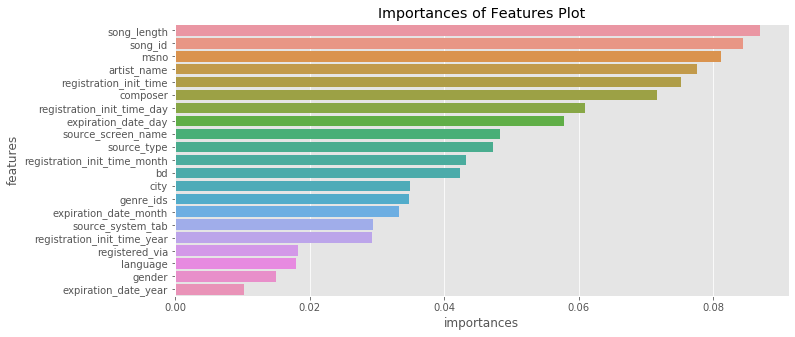

In [23]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [24]:
# Drop columns with importances < 0.04
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [32]:
# Selected columns
df.columns

Index(['msno', 'song_id', 'source_screen_name', 'source_type', 'song_length',
       'artist_name', 'composer', 'bd', 'registration_init_time',
       'registration_init_time_month', 'registration_init_time_day',
       'expiration_date_day'],
      dtype='object')

# XGBOOST

In [33]:
target = df.pop('target')
target

0        0
1        0
2        0
3        1
4        0
5        1
6        0
7        0
8        1
9        0
10       0
11       0
12       1
13       0
14       1
15       0
16       0
17       1
18       0
19       0
20       0
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
73744    0
73745    0
73746    0
73747    0
73748    1
73749    0
73750    0
73751    1
73752    0
73753    0
73754    1
73755    0
73756    1
73757    1
73758    0
73759    1
73760    1
73761    1
73762    1
73763    1
73764    0
73765    0
73766    1
73767    1
73768    0
73769    0
73770    0
73771    0
73772    0
73773    1
Name: target, Length: 73774, dtype: int64

In [36]:
# Train & Test split
train_data, test_data, train_labels, test_labels = train_test_split(df, target, test_size = 0.3)

# Delete df
del df

In [37]:
# Create model
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
# Predicting
predict_labels = model.predict(test_data)

In [39]:
print(metrics.classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61     11018
           1       0.62      0.64      0.63     11115

    accuracy                           0.62     22133
   macro avg       0.62      0.62      0.62     22133
weighted avg       0.62      0.62      0.62     22133

